## 1. Nigerian Sign Language (NSL)
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of Nigerian Sign Language (NSL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with, corresponding to the training and test datasets, respectively.</li>
</ul>

In [1]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.random.set_seed(2)
from datasets import sign_language
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = sign_language.load_data(container_path="datasets")

## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

In [4]:
original = tf.constant([[[1.0, 2.0, 3.0]]])
converted = tf.image.rgb_to_grayscale(original)
print(converted.numpy())

[[[1.8149]]]


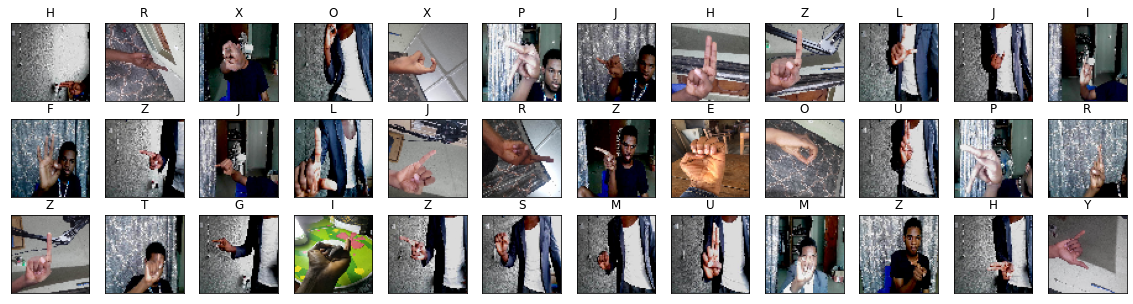

In [5]:
# Store labels of dataset
labels = []

for letter in range(65, 91):
    labels.append(chr(letter))

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [6]:
len(labels)

26

## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [7]:
num_train = []

for nums in range(26):
    num_train.append(sum(y_train==nums))

num_of_trains = list(zip(labels, num_train))
# Number of A's in the training dataset
# num_A_train = sum(y_train==0)

num_test = []

for nums in range(26):
    num_test.append(sum(y_test==nums))

num_of_tests = list(zip(labels, num_test))
# Number of A's in the test dataset
# num_A_test = sum(y_test==0)

# Print statistics about the dataset
print("Training set:")
print(num_of_trains)
#print("\tA: {}, B: {}, C: {}, D: {}, E: {}".format(num_A_train, num_B_train, num_C_train, num_D_train, num_E_train))
print("Test set:")
print(num_of_tests)
#print("\tA: {}, B: {}, C: {}, D: {}, E: {}".format(num_A_test, num_B_test, num_C_test, num_D_test, num_E_test))

Training set:
[('A', 48), ('B', 72), ('C', 48), ('D', 91), ('E', 87), ('F', 94), ('G', 51), ('H', 114), ('I', 73), ('J', 197), ('K', 84), ('L', 77), ('M', 101), ('N', 59), ('O', 71), ('P', 98), ('Q', 64), ('R', 97), ('S', 70), ('T', 82), ('U', 81), ('V', 106), ('W', 95), ('X', 111), ('Y', 95), ('Z', 155)]
Test set:
[('A', 13), ('B', 19), ('C', 18), ('D', 23), ('E', 27), ('F', 24), ('G', 14), ('H', 23), ('I', 25), ('J', 38), ('K', 19), ('L', 18), ('M', 29), ('N', 12), ('O', 20), ('P', 20), ('Q', 16), ('R', 18), ('S', 18), ('T', 26), ('U', 20), ('V', 24), ('W', 22), ('X', 26), ('Y', 28), ('Z', 41)]


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code>, <code>'C'</code>, <code>'D'</code>  and <code>'E'</code> are encoded as <code>0</code>, <code>1</code>, <code>2</code>, <code>3</code>   and <code>4</code>, respectively.  However, Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0, 0, 0]</code>, </li>
<li><code>2</code> is encoded as <code>[0, 0, 1, 0, 0]</code>, </li>
<li><code>3</code> is encoded as <code>[0, 0, 0, 1, 0]</code>, </li>
<li><code>4</code> is encoded as <code>[0, 0, 0, 0, 1]</code>, </li>
</ul>

In [8]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train, len(labels))

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test, len(labels))

##Data Augmentation

## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from tensorflow.keras import Sequential

size = 64 #image size
pool = 2 #size of pooling box
channel = 3 #no. of channels

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(size, size, channel)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(pool, pool), strides=None,
                      padding="valid"))
# Add a convolutional layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(pool, pool), strides=None,
                      padding="valid"))
# Add yet another convolutional layer
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
# And yet another max pooling layer
model.add(MaxPooling2D(pool_size=(pool, pool), strides=None,
                      padding="valid"))
#apply dropout because of our small datatset
#model.add(Dropout(0.5))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [11]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [ ]:
epochs = 300

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", #note in the report that metric measured was the loss
    patience=10,
    verbose=2
)
#  Train the model
hist = model.fit(x_train, y_train_OH, batch_size=32, epochs=epochs, callbacks=[early_stopping])

Epoch 1/300


## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

In [29]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.7676056623458862


## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

In [ ]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_test!=y_preds)[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,4))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs)/2), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

In [ ]:
def sign_predict(image):
    x = sign_language.paths_to_tensor(image).astype('float32')/255
    probs = model.predict(x)
    preds = np.argmax(probs, axis=1)
    return preds

In [ ]:
model.save('saved_model/my_model')